# Producing figures and numbers for split MNIST and contextual split MNIST and also SGD and lower learning rate numbers 


In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm, trange
from utils import get_logs_and_files, convert_train_to_test_idx

In [2]:
def load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset):
    search_strs=[f'seed{seed}_', f'tasks_{no_of_tasks}_',dataset, f'{var1:3.1f}_{var3:1.1f}_{var4:1.1f}']
    testing_logs, test_files = get_logs_and_files(data_folder, exp_name, file_sig='testing_log', search_strs=search_strs)
    training_logs, train_files = get_logs_and_files(data_folder, exp_name, file_sig='training_log', search_strs=search_strs)
    configs, config_files = get_logs_and_files(data_folder, exp_name, file_sig='config', search_strs=search_strs)
    config_files
    
    if len(training_logs) > 0:
        testing_log = testing_logs[0]
        training_log = training_logs[0]
        config = configs[0]
        assert len(training_logs) == 1, 'more than one training_log found!'
    else:
        print( f'unable to load {search_strs}!')
        testing_log, training_log, config = None, None, None        
    return config,training_log,testing_log



data_folder = './../files/cluster_2/'
# data_folder = './../files/cluster_split_mnist_from_branch_work/random_gates_mul/'
data_folder = './../files/cluster_split_mnist_sparsity_rehearsal/random_gates_mul/'
data_folder = './../files/cluster_split_mnist_sparsity_rehearsal_5tasks/random_gates_mul/' # Final results for split MNIST
data_folder = './../files/paper_data/cluster_split_mnist_sparsity_rehearsal_5tasks_testing_dataset/random_gates_mul/' # Final results for split MNIST
dataset = 'split_mnist'
exp_name= ''
seed = 14
var1 = 0.8
var3 = 1000.0
var4 = 1.0
no_of_tasks = 5
# dataset = 'neurogym'
# var3 = 1.0


config, training_log, testing_log = load_simulation(data_folder, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)

final avg acc 0.96799994


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


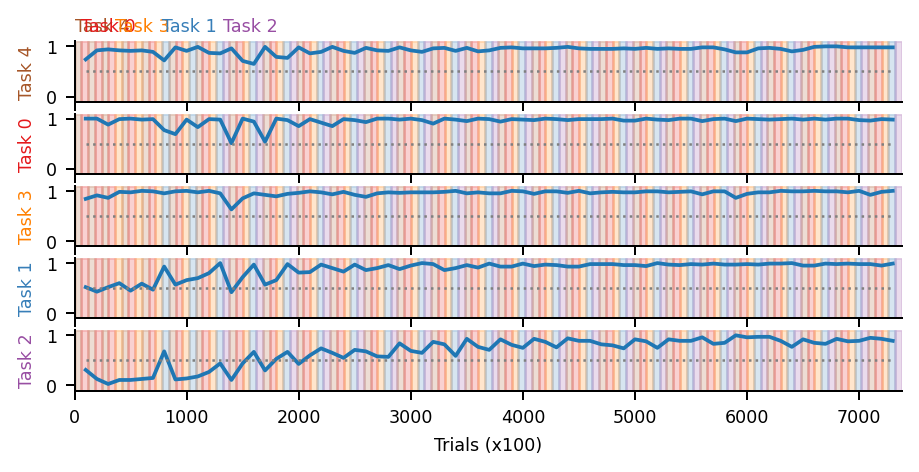

In [3]:
label = exp_name

config.tasks = config.tasks[:14]
no_of_values = 6
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

log = testing_log
# training_log.switch_trialxxbatch.append(training_log.stamps[-1])
config.human_task_names = [name.replace('class', 'Task ') for name in config.human_task_names]
switches = training_log.switch_trialxxbatch + [training_log.stamps[-1]]
num_tasks = len(config.tasks)
already_seen =[]
title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
if hasattr(training_log, 'start_optimizing_at'):
        max_x = training_log.start_optimizing_at #training_log.switch_trialxxbatch[num_tasks] #* config.print_every_batches
elif hasattr(training_log, 'start_testing_at'):
        max_x = training_log.start_testing_at #training_log.switch_trialxxbatch[num_tasks] #* config.print_every_batches
else:
        max_x = training_log.stamps[-1]
        # max_x = 3000
fig, axes = plt.subplots(num_tasks,1, figsize=[15/2.53,6.5/2.53])
for i, (tid, tn) in enumerate(config.tasks_id_name[:num_tasks]):
        # print(f'currently plot i {i} tid: {tid}  and tn {tn} ')
        ax = axes[ i ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        ax.plot(log.stamps, [test_acc[tid] for test_acc in log.accuracies], linewidth=1.5)
        ax.plot(log.stamps, np.ones_like(log.stamps)*0.5, ':', color='grey', linewidth=1)
        ax.set_ylabel(tn[7:-3].replace('class', 'Task '), fontdict={'color': cmap.to_rgba(tid)})
        for ri in range(len(training_log.switch_trialxxbatch)):
                ax.axvspan(switches[ri], switches[ri+1], color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.2)
        xtl = ax.get_xticklabels()
        if not (i +1== num_tasks):        ax.set_xticklabels([])
for ti, id in enumerate(training_log.switch_task_id):
    if id not in already_seen and (training_log.switch_trialxxbatch[ti] < max_x):
        if len(already_seen) >= num_tasks: break # do not go beyond how many tasks are to be displayed
        already_seen.append(id)
        task_name = config.human_task_names[id]
        axes[0].text(training_log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )
# axes[0].text(400, 1.7, 'Tasks being trained -->', color= 'black', fontsize=6 ,)
# axes[4].text(-0.1, 0.1, 'Accuracy on other tasks via latent updates', color= 'black', fontsize=6 ,rotation=90, transform=axes[4].transAxes)
axes[-1].set_xlabel('Trials (x100)')
final_accuracy_average = np.mean(list(testing_log.accuracies[-1].values()))
print('final avg acc', final_accuracy_average)
plt.savefig('./files/pdfs/thalamus_full_training_sequential.pdf', dpi=300)

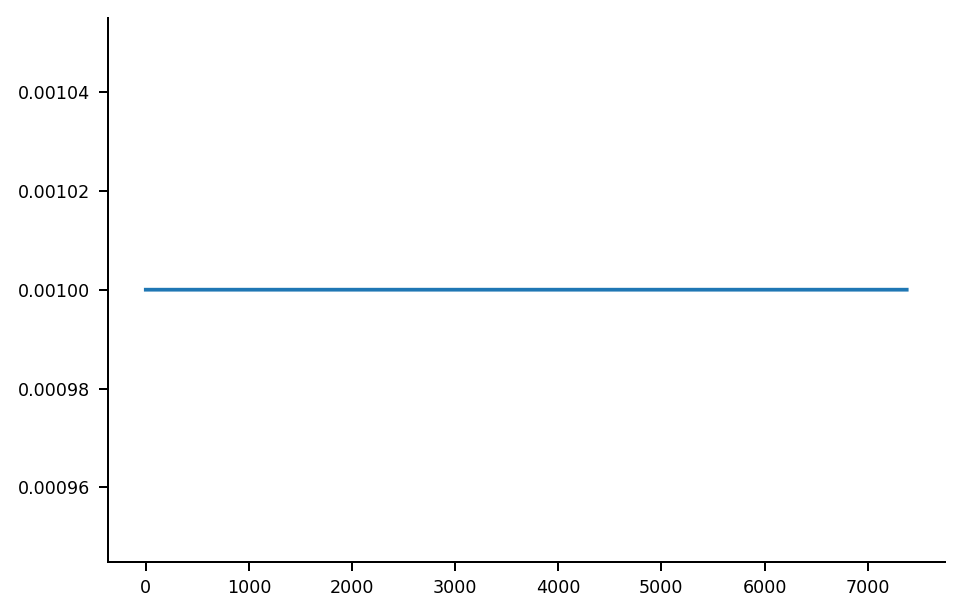

In [4]:
plt.plot(training_log.lrs)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


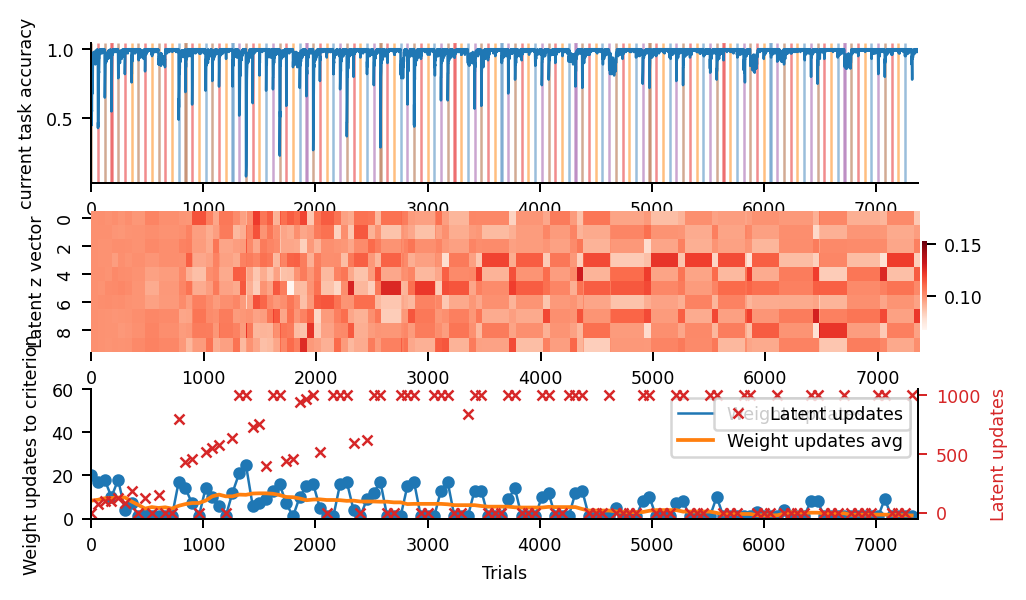

In [3]:
def plot_long_term_cluster_discovery( config, training_log, testing_log):
    # if len(training_log.bu_context_ids) > 0: context_ids =  training_log.bu_context_ids
    if len(training_log.td_context_ids) > 0: context_ids =  training_log.td_context_ids
    elif len(training_log.md_context_ids) > 0: context_ids =  training_log.md_context_ids
    else: 
        policy_context_id = np.ones([1,config.md_size])/config.md_size
        context_ids = [policy_context_id.repeat(config.batch_size, 0)] * training_log.stamps[-1]


    x0, x1 = 0,  training_log.stamps[-1]
    no_of_values = 6
    norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
    cmap_obj = mpl.cm.get_cmap('Set1') # tab20b tab20
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

    switches=  training_log.switch_trialxxbatch[:] 
    # switches=  training_log.switch_trialxxbatch[1:] # earlier on I must have added zero as a switch trial 
# [15/2.53,6.5/2.53]
    fig, axes = plt.subplots(3,1, figsize=[15/2.53,3.5], sharex = False)

    ax = axes[0]
    # ax.set_position(mpl.transforms.Bbox([[0.125, 0.715], [.747, 0.880]]))
    ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1], linewidth=1)
    for ri in range(len(switches)-1):
        ax.axvspan(training_log.switch_trialxxbatch[ri], training_log.switch_trialxxbatch[ri]+1, color =cmap.to_rgba(training_log.switch_task_id[ri]) , alpha=0.5)
        id = training_log.switch_task_id[ri]
        task_name = config.human_task_names[id]
        # ax.text(training_log.switch_trialxxbatch[ri], 1.0 + np.random.uniform(-0.1, 0.25), task_name, color= cmap.to_rgba(id) , fontsize=7)
    ax.set_ylabel('current task accuracy')
    ax.set_xlim([x0, x1])
    # print('axis 0 position: ',ax.get_position())
    
    ax = axes[1] # context ids
    md = np.stack([m[0] for m in context_ids])
    # print(fig.get_axes())
    im = sns.heatmap(md.T, cmap='Reds', ax = ax)#, vmax=md.max()/3)
    # print(fig.get_axes())
    # print('colorbar pos:', fig.get_axes()[-1].get_position())
    fig.get_axes()[-1].set_position(mpl.transforms.Bbox([[0.9037,0.39],[.90785, 0.600]]))
    # ax.get_shared_x_axes().join(ax, axes[0])
    ax.set_xticks(axes[0].get_xticks()[:-1])
    ax.set_xticklabels(axes[0].get_xticklabels()[:-1], rotation=0)
    # ax.set_xlabel('Batches (100 trials)')
    ax.set_ylabel('Latent z vector')
    ax.set_position(mpl.transforms.Bbox([[0.125,0.39],[.902, 0.613]]))
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.52],[.99, 0.683]]))
    # print(ax.get_position())

    ax = axes[2] # mean_bu
    # ax.plot(np.array(training_log.stamps)[x0:x1], np.array(training_log.accuracies)[x0:x1])
    # ax.set_xlim([x0, x1])
    # ax.set_ylabel('current task accuracy')
    # ax.set_xlabel('Batches (100 trials)')
    # # print(ax.get_position())
    # # =0.125, y0=0.32195652173913036, x1=0.9, y1=0.4860869565217391
    # ax.set_position(mpl.transforms.Bbox([[0.125,0.32],[.9, 0.45]]))
    # ax.plot(training_log.trials_to_crit, label = 'trials to crit')
    ax.plot(training_log.switch_trialxxbatch, training_log.trials_to_crit, label = 'Weight updates', color='tab:blue', linewidth=1)
    ax.plot(training_log.switch_trialxxbatch,training_log.trials_to_crit, 'o', markersize=4, color='tab:blue')
    filter=10
    filtered_mean = np.convolve(np.array(training_log.trials_to_crit), np.ones(filter)/filter, 'same')
    ax.plot(training_log.switch_trialxxbatch,filtered_mean, label=f'Weight updates avg', color='tab:orange',)
    mpl.rcParams['axes.spines.right'] = True
    ax2 =  ax.twinx()
    ax2.set_ylabel('Latent updates', color= 'tab:red') 
    ax2.plot(training_log.switch_trialxxbatch,np.clip(np.array(training_log.latents_to_crit),0, a_max=1000), 'x',markersize=4,color='tab:red', label = 'Latent updates')
    # ax2.plot([la[0]for la in training_log.lu_stamps_acc_improve], np.stack([la[1]for la in training_log.lu_stamps_acc_improve])*1000, '.', color='tab:green')
    ax2.tick_params(axis='y', color='tab:red', labelcolor='tab:red')
    mpl.rcParams['axes.spines.right'] = False
    ax.set_ylabel('Weight updates to criterion')
    ax.set_xlabel('Trials')
    ax.set_xlim([x0, x1])
    ax.set_ylim(0, 60)#filtered_mean.max()*1.5)
    if hasattr(training_log, 'converged_detected_at'):
        ax.axvline(training_log.converged_detected_at, color='tab:green', alpha=0.5, linewidth=2, label='Converged')
    ax.legend()
    ax2.legend()
    # print(ax.get_position())
    ax.set_position(mpl.transforms.Bbox([[0.125,0.125],[.90, 0.33]]))
    identifiers = 9
    
    plt.savefig('./files/pdfs/SplitMNIST_thalamus.pdf', dpi=300)

plot_long_term_cluster_discovery(config, training_log, testing_log)

In [35]:
# experiments = ['random_gates_mul']
exp_name = 'random_gates_mul'
dataset= 'split_mnist'
folder_name = './../files/cluster_split_mnist_sparsity_rehearsal_5tasks_contextual/' # Results for contexual split mnist but testing on training by mistake.
folder_name = './../files/paper_data/cluster_split_mnist_sparsity_rehearsal_5tasks_testing_dataset/' # Final results from 5 tasks learning and testing on test dataset
# folder_name = './../files/cluster_split_mnist_WU_optimizers/' # 

# config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var2, var3, var4, no_of_tasks)

data = defaultdict(list)
no_of_tasks_to_assess_accuracy_on = 5
################################### load only 4 here if want to test generalization to 5th task ###############################
no_of_tasks = 5        ################################### load only 4 here if want to test generalization to 5th task ###############################
################################### load only 4 here if want to test generalization to 5th task ###############################

Seeds = range(0,20)#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [0.8] # no of latent updates  #[(x/10) for x in [10]]#range(5,14, 2)] # gates_mean  #0 1 add mul 
Var2 = [no_of_tasks] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [1000] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [1] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exps=[]
# expVars =  [[seed, experiment, x1, x2, x3, x4] for seed in Seeds for experiment in experiments for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
for jobi, par_set in enumerate(expVars):
    seed, var1, var2, var3, var4 = par_set
    config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
    if not config is None: # if exp actually loaded and exists.
        print(config.exp_signature, '     fd ', f'var1 {var1},  var2 {var2},  var3 {var3},,   var4 {var4},  noof tasks {no_of_tasks}, dataset {dataset}')
        exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
        data['ttcs'].append(training_log.trials_to_crit[:])
        data['total_batches'].append(training_log.stamps[-1])
        data['end_avg_acc'].append(np.mean(list(testing_log.accuracies[-1].values())))
        data['end_avg_acc_top'].append(np.max([np.mean(list(testing_log.accuracies[i].values())) for i in range(len(testing_log.accuracies))]))
        for tid in range(no_of_tasks_to_assess_accuracy_on):
            data[f'accs{tid}'].append([test_acc[tid] for test_acc in testing_log.accuracies])

seed0_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed1_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed2_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed3_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed4_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed5_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed6_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000,,   var4 1,  noof tasks 5, dataset split_mnist
seed7_mul_tasks_5_split_mnist0.8_1000.0_1.0_      fd  var1 0.8,  var2 5,  var3 1000

In [36]:
data['end_avg_acc_top']

[0.972,
 0.974,
 0.982,
 0.9799999,
 0.9839999,
 0.974,
 0.9799999,
 0.978,
 0.96999997,
 0.97599995,
 0.984,
 0.98800004,
 0.978,
 0.976,
 0.98,
 0.96599996,
 0.98,
 0.972,
 0.978,
 0.96999997]

In [38]:
print('end_avg_acc_top: ',np.mean(data['end_avg_acc_top']))
print('end_std_acc_top: ',np.std(data['end_avg_acc_top']))


print('end_avg_acc: ',np.mean(data['end_avg_acc']))
print('end_std_acc: ',np.std(data['end_avg_acc']))
# [exp for exp in exps if exp['seed'] ==2]
# [exps[i] for i in range (len(exps)) if exps[i]['var1'] == sparsity1 and exps[i]['var2'] == no_of_tasks and exps[i]['var3'] == 1000.0 and exps[i]['var4'] == 1.0]

end_avg_acc_top:  0.9771
end_std_acc_top:  0.0053469655
end_avg_acc:  0.9539
end_std_acc:  0.0134085715


In [3]:
sparsity1 = 0.8
def get_task_accs (tid):
    task_accs = ([data[f'accs{tid}'][i]  for i in range(len(data[f'accs{tid}'])) if exps[i]['var1'] == sparsity1 and exps[i]['var2'] == no_of_tasks and exps[i]['var3'] == 1000.0 and exps[i]['var4'] == 1.0])
    return task_accs


[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73]
[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73]


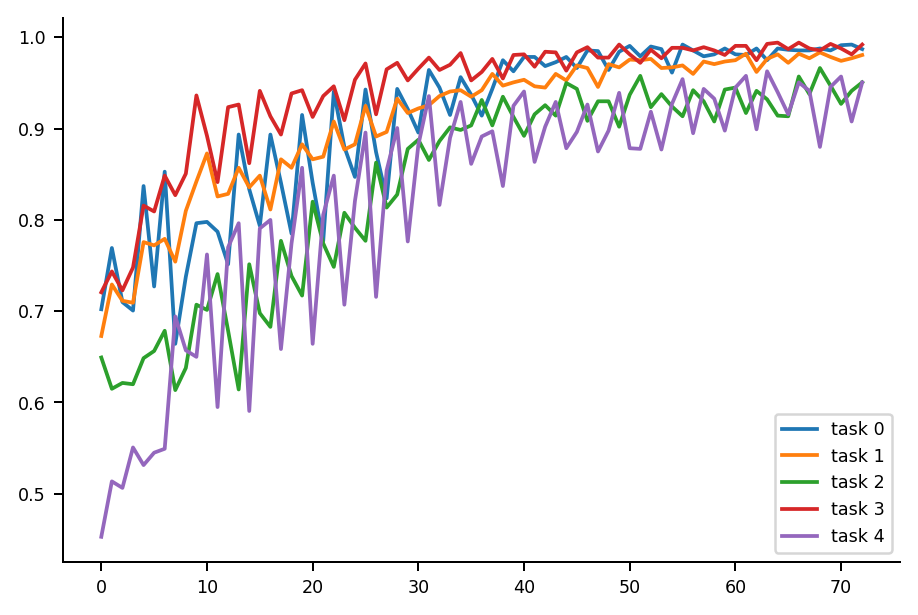

In [22]:
ax = plt.gca()
for task_i in range(5):

    task_accs = get_task_accs(task_i)
    print([len(ta) for ta in task_accs])
    ta = np.array(task_accs)
    ax.plot(ta.mean(0), label=f'task {task_i}')
ax.legend()


In [23]:
metrics_dict= np.load('./all_metric_dics.npy', allow_pickle=True)
metrics_dict_ER= np.load('./all_metric_dics_ER.npy', allow_pickle=True)

NONE, OFF, EWC, OEWC, SI, = metrics_dict
LWF, RP, RKD, AGEM, ER = metrics_dict_ER

def plot_accuracies(baseline, baseline_name, ax, color, marker):
    accuracy_table = {}
    seeds = [1,2,3,4,5]
    for i in range(1,6):
        accs= []
        for seed in seeds:
            # metric[seed][0]['acc per task'].keys() # dict_keys(['task 1', 'task 2', 'task 3', 'task 4', 'task 5'])
            accs.append(baseline[seed][0]['acc per task'][f'task {i}'])
        accuracy_table.update({i: np.array(accs)})


    colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:blue', 'tab:green', 'tab:blue']
    task_i =5
    ta = accuracy_table[task_i]
    # print('ta shape: ', ta.shape)
    ax.plot(range(1, 6), ta.mean(0), marker=marker,  color=color , label=baseline_name)
    # ax.plot(range(1, 6), ta.mean(0),  color=color  )
    ax.errorbar(range(1, 6), ta.mean(0), ta.std(0)/np.sqrt(5), color=color )
    ax.set_ylim([0.4,1])
    ax.axhline(0.5, linestyle=':')
    # ax.set_title(baseline_name)
    ax.set_xlabel('Task being learned')
    ax.set_ylabel('Last task accuracy')
    ax.legend()





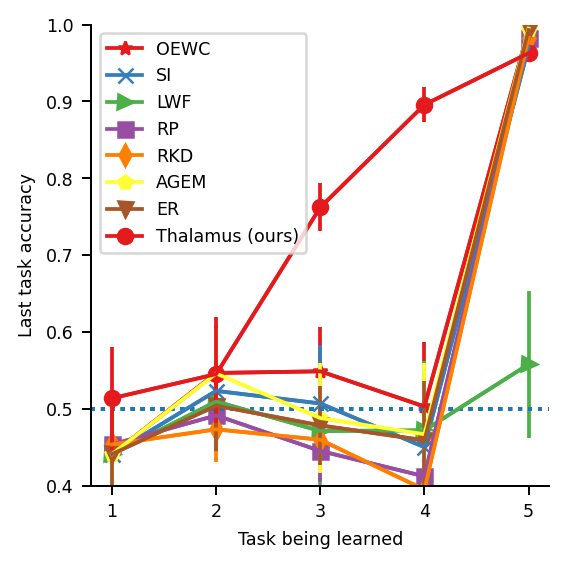

In [36]:
fig, ax = plt.subplots(1,1, figsize=[8/2.53,8/2.53])

no_of_values = 10
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
markers = [ '*', 'x', '>', 's', 'd', 'p', 'v', '^', '1', '3', '4']

baselines=      [OEWC, SI, LWF, RP, RKD, AGEM, ER] 
baseline_names= ['OEWC', 'SI', 'LWF', 'RP', 'RKD', 'AGEM', 'ER']
for i, (baseline, baseline_name) in enumerate(zip(baselines, baseline_names)):
    plot_accuracies(baseline,  baseline_name, ax, cmap.to_rgba(1+i), markers[i])

samples = [1, 5, 10, 25, -10]
task_i = 4
task_accs = get_task_accs(task_i)
ta = np.array(task_accs)
# ax.plot(np.convolve(ta.mean(0), np.ones(4)/4, "valid"), label=f'smooth task {task_i}')
ax.plot(range(1,6), ta.mean(0)[samples], marker='o', label='Thalamus (ours)', color = cmap.to_rgba(0))
# ax.plot(range(1,5), ta.mean(0)[[0, 10, 30, -1]], , label=f'task {task_i}')
ax.errorbar(range(1,6), ta.mean(0)[samples], ta.std(0)[samples]/np.sqrt(20), color = cmap.to_rgba(0))
ax.legend()
# [2,2,20,] # 1 2  1 2 3     1 2 3 4 
# 60 per block.
# First task came in first block for 60 trials.. so testing every 100. Means I should pick the first reading
# Second task came in at second block. 120 trials. then 1 2 where rehearsed. Total 240, I'll pick 300
# Third task came in at 60 * 2 * 2    and exited at  60 * 3 * 2 So I'll pick 600
# fourth task rehearsala ended at the end

    
fig.tight_layout()
plt.savefig('./files/pdfs/last_task_accuracy_baselines.pdf', dpi=300)

# Trying the new results with varying WU optimizers. 

In [51]:
# experiments = ['random_gates_mul']
exp_name = 'random_gates_mul'
dataset= 'split_mnist'
folder_name = './../files/cluster_split_mnist_sparsity_no_convergence/'
folder_name = './../files/cluster_split_mnist_sparsity_rehearsal/'                   # 
folder_name = './../files/paper_data/cluster_split_mnist_WU_optimizers/' # Results from varying learning rates and all for WU optimizers and switching between adam and SGD
# folder_name = './../files/paper_data/cluster_split_mnist_contextual_proper_testing/' # NOT valid. used SGD for LUs. Results for contexual split mnist

# config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var2, var3, var4, no_of_tasks)
# folder_name = './../files/cluster_split_mnist_contextual_proper_testing_ADAM_LU/' # Results for contexual split mnist
data = defaultdict(list)
no_of_tasks_to_assess_accuracy_on = 5
no_of_tasks = 4

Seeds = range(0,10)#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [0.0, 1.0] # 0 for SGD and 1 for Adam
Var2 = [no_of_tasks] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [0.1, 1, 10, 100] # LR multplier   # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exps=[]
# expVars =  [[seed, experiment, x1, x2, x3, x4] for seed in Seeds for experiment in experiments for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
for jobi, par_set in enumerate(expVars):
    seed, var1, var2, var3, var4 = par_set
    config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
    if not config is None: # if exp actually loaded and exists.
        print(config.exp_signature, '     fd ', f'var1 {var1},  var2 {var2},  var3 {var3},,   var4 {var4},  noof tasks {no_of_tasks}, dataset {dataset}')
        exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
        data['ttcs'].append(training_log.trials_to_crit[:])
        data['total_batches'].append(training_log.stamps[-1])
        data['end_avg_acc'].append(np.mean(list(testing_log.accuracies[-1].values())))
        data['end_avg_acc_top'].append(np.max([np.mean(list(testing_log.accuracies[i].values())) for i in range(len(testing_log.accuracies))]))
        for tid in range(no_of_tasks_to_assess_accuracy_on):
            data[f'accs{tid}'].append([test_acc[tid] for test_acc in testing_log.accuracies])

seed0_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist0.0_1.0_0.0_      fd  var1 0.0,  var2 4,  var3 1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist0.0_10.0_0.0_      fd  var1 0.0,  var2 4,  var3 10,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist0.0_100.0_0.0_      fd  var1 0.0,  var2 4,  var3 100,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist1.0_0.1_0.0_      fd  var1 1.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist1.0_1.0_0.0_      fd  var1 1.0,  var2 4,  var3 1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist1.0_10.0_0.0_      fd  var1 1.0,  var2 4,  var3 10,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed0_mul_tasks_4_split_mnist1.0_100.0_0.0_      fd  var1 1.0,  var2 4,  var3 100,,   var4 0.0,  no

In [52]:
Seeds = range(0,10)#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [0.0, 1.0] # 0 for SGD and 1 for Adam
Var2 = [no_of_tasks] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [0.1, 1, 10, 100] # LR multplier   # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
def get_results(Seeds, Var1, Var2, Var3, Var4, no_of_tasks):
    exps=[]
    data = defaultdict(list)
    # expVars =  [[seed, experiment, x1, x2, x3, x4] for seed in Seeds for experiment in experiments for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
    expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
    for jobi, par_set in enumerate(expVars):
        seed, var1, var2, var3, var4 = par_set
        config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
        if not config is None: # if exp actually loaded and exists.
            print(config.exp_signature, '     fd ', f'var1 {var1},  var2 {var2},  var3 {var3},,   var4 {var4},  noof tasks {no_of_tasks}, dataset {dataset}')
            exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
            data['ttcs'].append(training_log.trials_to_crit[:])
            data['total_batches'].append(training_log.stamps[-1])
            data['end_avg_acc'].append(np.mean(list(testing_log.accuracies[-1].values())))
            data['end_avg_acc_top'].append(np.max([np.mean(list(testing_log.accuracies[i].values())) for i in range(len(testing_log.accuracies))]))
            for tid in range(no_of_tasks_to_assess_accuracy_on):
                data[f'accs{tid}'].append([test_acc[tid] for test_acc in testing_log.accuracies])
    return data

no_of_tasks = 4
Var1=[0.0]
Var3=[0.1]
data = get_results(Seeds, Var1, Var2, Var3, Var4, no_of_tasks)
dd = data['end_avg_acc_top']
print('end_avg_acc_top: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')

dd = data['end_avg_acc']
print('end_avg_acc: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')
dd = [d[-1] for d in data['accs4']]
print('Last task accuracy: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')
dd = [[d[-1] for d in data[f'accs{i}']] for i in range(3)]
print('First tasks accuracy: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')


seed0_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed1_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed2_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed3_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed4_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed5_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed6_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  noof tasks 4, dataset split_mnist
seed7_mul_tasks_4_split_mnist0.0_0.1_0.0_      fd  var1 0.0,  var2 4,  var3 0.1,,   var4 0.0,  no

In [49]:
#Contextual behavrio 
#Results for contexual split mnist
folder_name = './../files/paper_data/cluster_split_mnist_contextual_proper_testing_ADAM_LU/' # This is the final test for contextal split MNIST, test prior confusingly used SGD for LU.
data = defaultdict(list)
no_of_tasks_to_assess_accuracy_on = 5
no_of_tasks = 5

Seeds = range(0,10)#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [1.0] # 0 for SGD and 1 for Adam
Var2 = [no_of_tasks] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [ 1] # LR multplier   # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [0.0] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exps=[]
# expVars =  [[seed, experiment, x1, x2, x3, x4] for seed in Seeds for experiment in experiments for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
for jobi, par_set in enumerate(expVars):
    seed, var1, var2, var3, var4 = par_set
    config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
    if not config is None: # if exp actually loaded and exists.
        print(config.exp_signature, '     fd ', f'var1 {var1},  var2 {var2},  var3 {var3},,   var4 {var4},  noof tasks {no_of_tasks}, dataset {dataset}')
        exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
        data['ttcs'].append(training_log.trials_to_crit[:])
        data['total_batches'].append(training_log.stamps[-1])
        data['end_avg_acc'].append(np.mean(list(testing_log.accuracies[-1].values())))
        data['end_avg_acc_top'].append(np.max([np.mean(list(testing_log.accuracies[i].values())) for i in range(len(testing_log.accuracies))]))
        for tid in range(no_of_tasks_to_assess_accuracy_on):
            data[f'accs{tid}'].append([test_acc[tid] for test_acc in testing_log.accuracies])
dd = data['end_avg_acc_top']
print('end_avg_acc_top: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')

dd = data['end_avg_acc']
print('end_avg_acc: ', f'{np.mean(dd)*100:2.2f}', '+- ', f'{np.std(dd)/np.sqrt(len(Seeds))*100:2.2f}')            

FileNotFoundError: [Errno 2] No such file or directory: './../files/paper_data/cluster_split_mnist_contextual_proper_testing_ADAM_LU/random_gates_mul/'

[[<matplotlib.lines.Line2D at 0x2b8920cd8b50>],

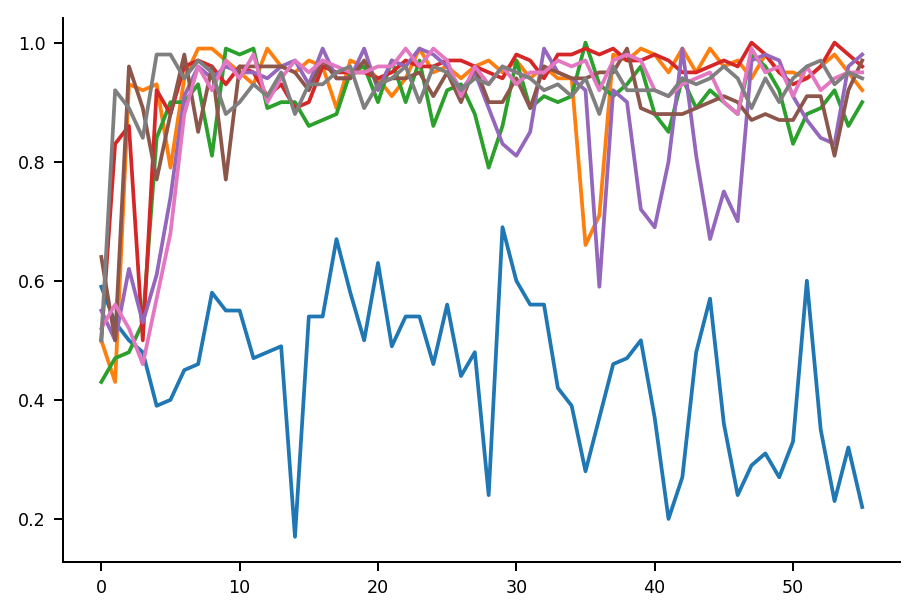

In [29]:
[plt.plot(d) for d in data['accs4']]

# Task 5 vs adaptation batch size

In [21]:
# experiments = ['random_gates_mul']
exp_name = 'few_shot_testing'
dataset= 'split_mnist'
folder_name = './../files/cluster_split_mnist_few_shot/' # 
data = defaultdict(list)
no_of_tasks_to_assess_accuracy_on = 5
no_of_tasks = 4 

Seeds = range(0,14)#[6, 7, 8, 10,  14, ]#range(11,15)
Var1 = [1.0] # no of latent updates  #[(x/10) for x in [10]]#range(5,14, 2)] # gates_mean  #0 1 add mul 
Var2 = [no_of_tasks] # used to pass no of exp  #[-0.3] #MDprob, currently gaussian cuttoff #[0.0001, 0.001]#range(0,3, 1) #gates mean
Var3 = [1] # [(x/10) for x in range(1,5, 1)] #gates_std  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
Var4 = [1, 2, 3 , 4, 5, 6, 8, 10, 20, 40,100] # [(x/10) for x in range(0,6, 4)] #gates_sparsity  #, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
exps=[]
expVars =  [[seed,  x1, x2, x3, x4] for seed in Seeds for x1 in Var1 for x2 in Var2 for x3 in Var3 for x4 in Var4 ]
for jobi, par_set in enumerate(expVars):
    seed, var1, var2, var3, var4 = par_set
    config, training_log, testing_log = load_simulation(folder_name, exp_name, seed, var1, var3, var4, no_of_tasks, dataset)
    if not config is None: # if exp actually loaded and exists.
        novel_task_id, novel_task_name = config.tasks_id_name[-1]
        # print(config.exp_signature, '     fd ', f'var1 {var1},  var2 {var2},  var3 {var3},,   var4 {var4},  noof tasks {no_of_tasks}, dataset {dataset}')
        exps.append({'var1': var1, 'var2': var2, 'var3': var3, 'no_of_tasks': no_of_tasks, 'seed': seed, 'var4': var4})
        data['ttcs'].append(training_log.trials_to_crit[:])
        data['total_batches'].append(training_log.stamps[-1])
        data['end_avg_acc'].append(np.mean(list(testing_log.accuracies[-1].values())))
        data['end_avg_acc_top'].append(np.max([np.mean(list(testing_log.accuracies[i].values())) for i in range(len(testing_log.accuracies))]))
        for tid in range(no_of_tasks_to_assess_accuracy_on):
            data[f'accs{tid}'].append([test_acc[tid] for test_acc in testing_log.accuracies])
        data[f'accsn'].append([test_acc[novel_task_id] for test_acc in testing_log.accuracies])

unable to load ['seed0_', 'tasks_4_', 'split_mnist', '1.0_1.0_100.0']!


(0.3, 1.0)

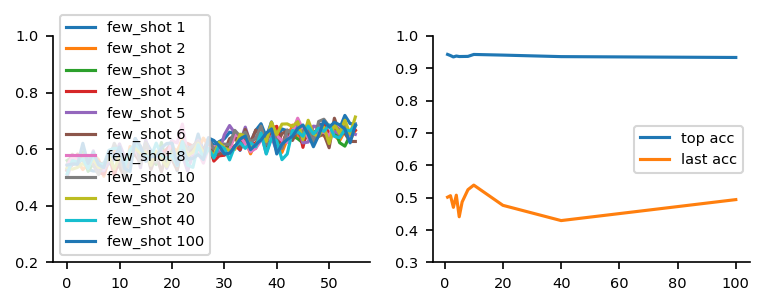

In [24]:
var1 = 1.0
var3= 1.0
fig, axes = plt.subplots(1,2, figsize=[6,2])
ax = axes[0]
ax.set_ylim([0.2,1])

ta, la = [], []
for var4 in Var4:
    datum = data['end_avg_acc_top']
    filtered_data = np.stack([datum[i]  for i in range(len(datum)) if exps[i]['var1'] == var1 and exps[i]['var3'] == var3 and exps[i]['var4'] == var4])
    top_all = filtered_data
    datum = data['accsn']
    filtered_data = np.stack([datum[i]  for i in range(len(datum)) if exps[i]['var1'] == var1 and exps[i]['var3'] == var3 and exps[i]['var4'] == var4])
    last_task_acc = filtered_data
    ta.append(np.mean(top_all))
    
    ax.plot(last_task_acc.mean(0), label=f'few_shot {var4}')#, alpha=0.7, linewidth=1)
    
    la.append(np.mean(last_task_acc[-1]))
ax.legend(loc = 'lower left')
ax = axes[1]
ax.plot(Var4, ta, label='top acc')
ax.plot(Var4, la, label='last acc')
ax.legend()
ax.set_ylim([0.3,1])


(0.2, 1.0)

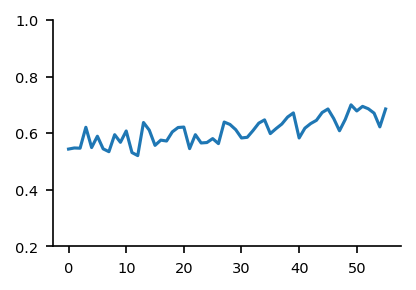

In [11]:
ttcs

array([0.9179999 , 0.96000004, 0.94399995, 0.934     , 0.9639999 ,
       0.92200005, 0.938     , 0.96599996, 0.928     , 0.95199996],
      dtype=float32)